In [ ]:
install.packages("tidyverse", repos = "http://cran.us.r-project.org")
install.packages("caret", repos = "http://cran.us.r-project.org")
install.packages("data.table", repos = "http://cran.us.r-project.org")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
dl <- tempfile()
download.file("http://files.grouplens.org/datasets/movielens/ml-1m.zip", dl)



In [ ]:
library(tidyverse)
library(caret)
library(data.table)
library(lubridate)
library(tinytex)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following

In [ ]:
ratings <- fread(text = gsub("::", "\t", 
                             readLines(unzip(dl, "ml-1m/ratings.dat"))),
                 col.names = c("userId", "movieId", "rating", "timestamp"))

movies <- str_split_fixed(readLines(unzip(dl, "ml-1m/movies.dat")), "\\::", 3)
colnames(movies) <- c("movieId", "title", "genres")
movies <- as.data.frame(movies) %>% 
  mutate(movieId = as.numeric(movieId),
         title = as.character(as.character(title)),
         genres = as.character(as.character(genres)))

movielens <- left_join(ratings, movies, by = "movieId")

# 'Validation' set will be 10% of MovieLens data
set.seed(1, sample.kind="Rounding")
test_index <- createDataPartition(y = movielens$rating, 
                                  times = 1, p = 0.1, list = FALSE)
edx <- movielens[-test_index,]
temp <- movielens[test_index,]

# Make sure userId and movieId in 'validation' set are also in 'edx' set
validation <- temp %>% 
  semi_join(edx, by = "movieId") %>%
  semi_join(edx, by = "userId")

# Add rows removed from 'validation' set back into 'edx' set
removed <- anti_join(temp, validation)
edx <- rbind(edx, removed)

rm(dl, ratings, movies, test_index, temp, movielens, removed)

Warning message in set.seed(1, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”
Joining, by = c("userId", "movieId", "rating", "timestamp", "title", "genres")



In [ ]:
set.seed(1, sample.kind="Rounding")
test_index <- createDataPartition(y = edx$rating, times = 1, p = 0.1, list = FALSE)
train_set <- edx[-test_index,]
temp <- edx[test_index,]

# Make sure userId and movieId in test set are also in train set
test_set <- temp %>% 
  semi_join(train_set, by = "movieId") %>%
  semi_join(train_set, by = "userId")

# Add rows removed from test set back into train set
removed <- anti_join(temp, test_set)
train_set <- rbind(train_set, removed)

rm(test_index, temp, removed)

Warning message in set.seed(1, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”
Joining, by = c("userId", "movieId", "rating", "timestamp", "title", "genres")



In [ ]:
str(edx)

Classes ‘data.table’ and 'data.frame':	900200 obs. of  6 variables:
 $ userId   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ movieId  : num  1193 661 914 3408 2355 ...
 $ rating   : int  5 3 3 4 5 3 5 5 4 4 ...
 $ timestamp: int  978300760 978302109 978301968 978300275 978824291 978302268 978302039 978300719 978301368 978302281 ...
 $ title    : chr  "One Flew Over the Cuckoo's Nest (1975)" "James and the Giant Peach (1996)" "My Fair Lady (1964)" "Erin Brockovich (2000)" ...
 $ genres   : chr  "Drama" "Animation|Children's|Musical" "Musical|Romance" "Drama" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [ ]:
dim(edx)

[1] 900200      6

In [ ]:
head(edx)

userId,movieId,rating,timestamp,title,genres
<int>,<dbl>,<int>,<int>,<chr>,<chr>
1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
1,914,3,978301968,My Fair Lady (1964),Musical|Romance
1,3408,4,978300275,Erin Brockovich (2000),Drama
1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
1,1197,3,978302268,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance


In [ ]:
library(lubridate)
tibble(`Initial Date` = date(as_datetime(min(edx$timestamp), origin="1970-01-01")),
       `Final Date` = date(as_datetime(max(edx$timestamp), origin="1970-01-01"))) %>%
  mutate(Period = duration(max(edx$timestamp)-min(edx$timestamp)))

Initial Date,Final Date,Period
<date>,<date>,<Duration>
2000-04-25,2003-02-28,89750658s (~2.84 years)


Loading required package: ggthemes

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ggthemes’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



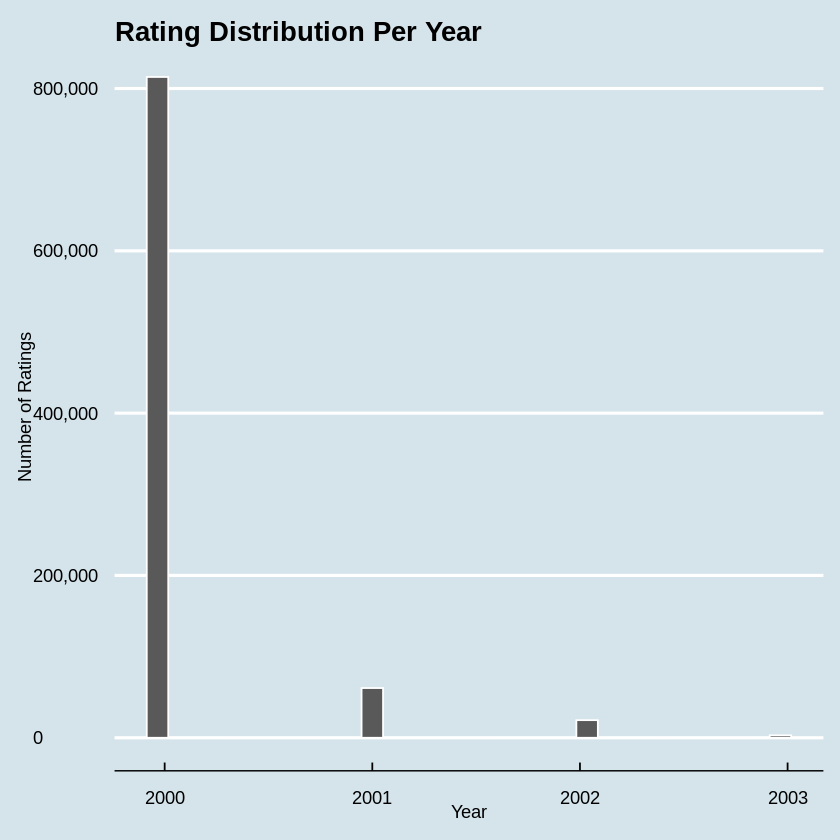

In [ ]:
if(!require(ggthemes)) 
  install.packages("ggthemes", repos = "http://cran.us.r-project.org")
if(!require(scales)) 
  install.packages("scales", repos = "http://cran.us.r-project.org")

library(scales)
library(ggthemes)

edx %>% mutate(year = year(as_datetime(timestamp, origin="1970-01-01"))) %>%
  ggplot(aes(x=year)) +
    geom_histogram(color = "white") + 
    ggtitle("Rating Distribution Per Year") +
    xlab("Year") +
    ylab("Number of Ratings") +
    scale_y_continuous(labels = comma) + 
    theme_economist()

In [ ]:
edx %>% mutate(date = date(as_datetime(timestamp, origin="1970-01-01"))) %>%
  group_by(date, title) %>%
  summarise(count = n()) %>%
  arrange(-count) %>%
  head(10)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



date,title,count
<date>,<chr>,<int>
2000-11-20,American Beauty (1999),307
2000-11-20,Jurassic Park (1993),220
2000-11-20,Terminator 2: Judgment Day (1991),220
2000-11-20,Braveheart (1995),212
2000-11-20,Men in Black (1997),208
2000-11-20,Star Wars: Episode IV - A New Hope (1977),208
2000-11-20,Star Wars: Episode VI - Return of the Jedi (1983),206
2000-11-20,Star Wars: Episode V - The Empire Strikes Back (1980),204
2000-11-20,Saving Private Ryan (1998),202


In [ ]:
edx %>% group_by(rating) %>% summarize(n=n())

rating,n
<int>,<int>
1,50469
2,96804
3,235174
4,314074
5,203679


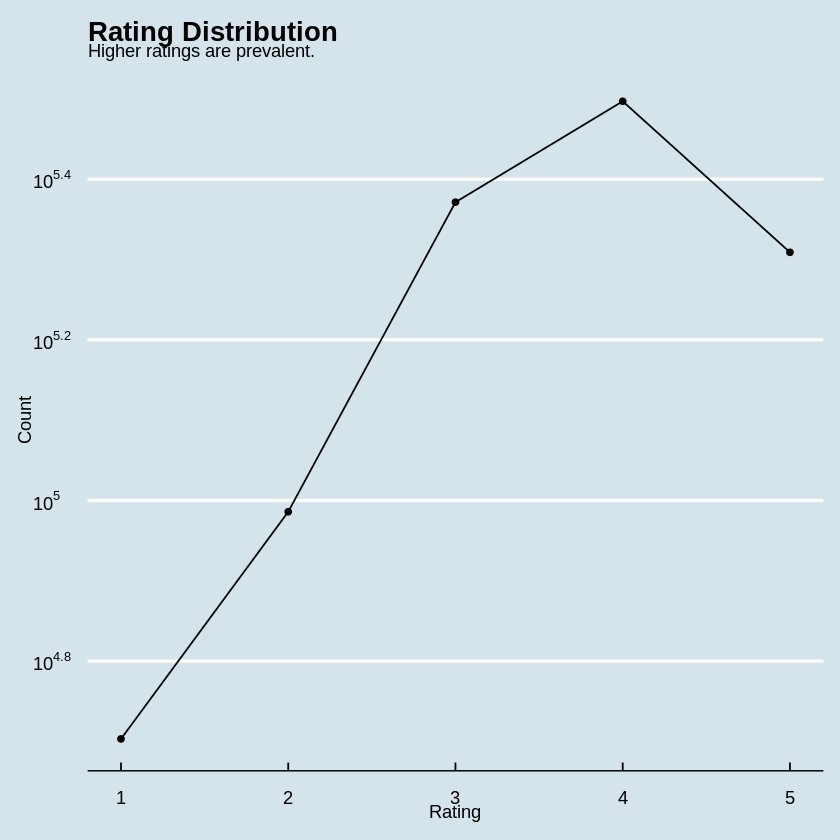

In [ ]:
edx %>% group_by(rating) %>% 
  summarise(count=n()) %>%
  ggplot(aes(x=rating, y=count)) + 
    geom_line() +
    geom_point() +
    scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
                labels = trans_format("log10", math_format(10^.x))) +
    ggtitle("Rating Distribution", subtitle = "Higher ratings are prevalent.") + 
    xlab("Rating") +
    ylab("Count") +
    theme_economist()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



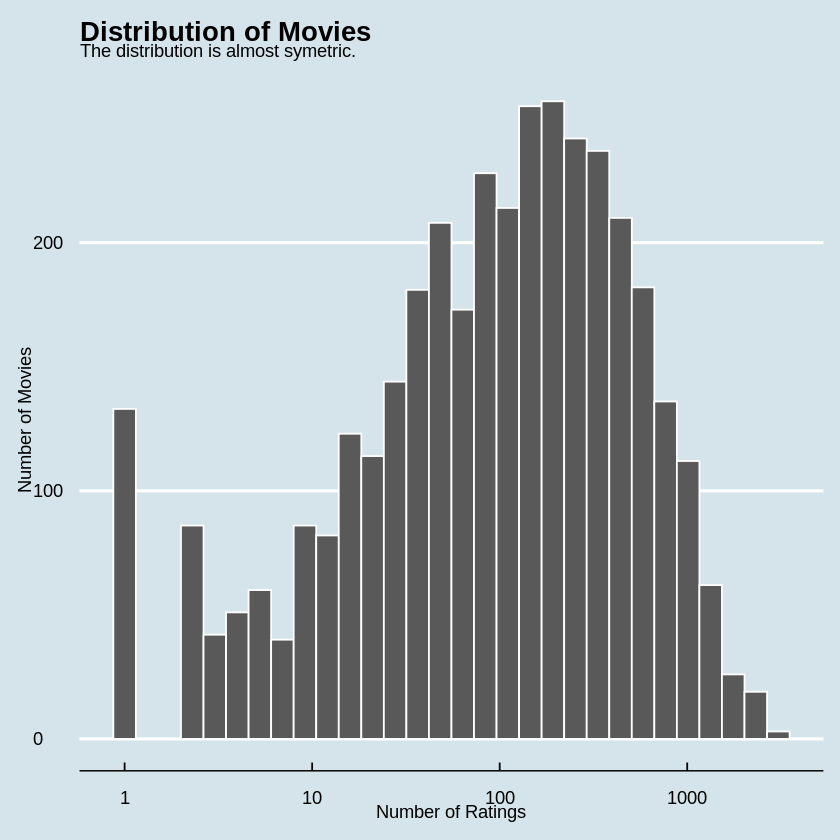

In [ ]:
edx %>% group_by(movieId) %>%
  summarise(n=n()) %>%
  ggplot(aes(n)) +
    geom_histogram(color = "white") +
    scale_x_log10() + 
    ggtitle("Distribution of Movies", 
            subtitle = "The distribution is almost symetric.") +
    xlab("Number of Ratings") +
    ylab("Number of Movies") + 
    theme_economist()

In [ ]:
edx %>% group_by(userId) %>%
  summarise(n=n()) %>%
  arrange(n) %>%
  head()

userId,n
<int>,<int>
761,14
1406,14
708,15
2488,15
158,16
226,16


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



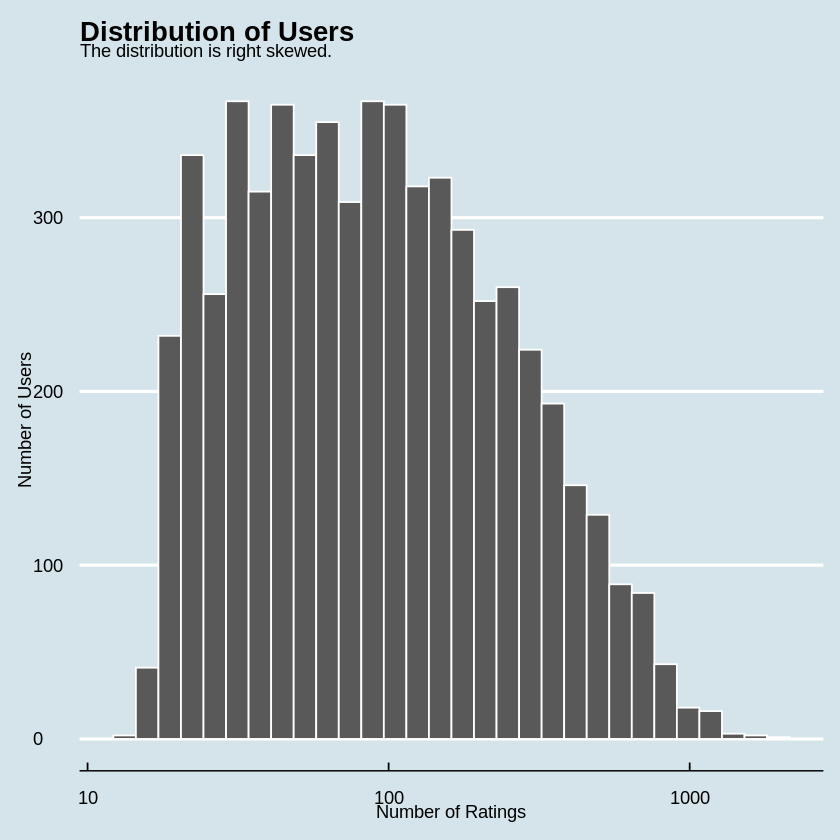

In [ ]:
edx %>% group_by(userId) %>%
  summarise(n=n()) %>%
  ggplot(aes(n)) +
    geom_histogram(color = "white") +
    scale_x_log10() + 
    ggtitle("Distribution of Users", 
            subtitle="The distribution is right skewed.") +
    xlab("Number of Ratings") +
    ylab("Number of Users") + 
    scale_y_continuous(labels = comma) + 
    theme_economist()


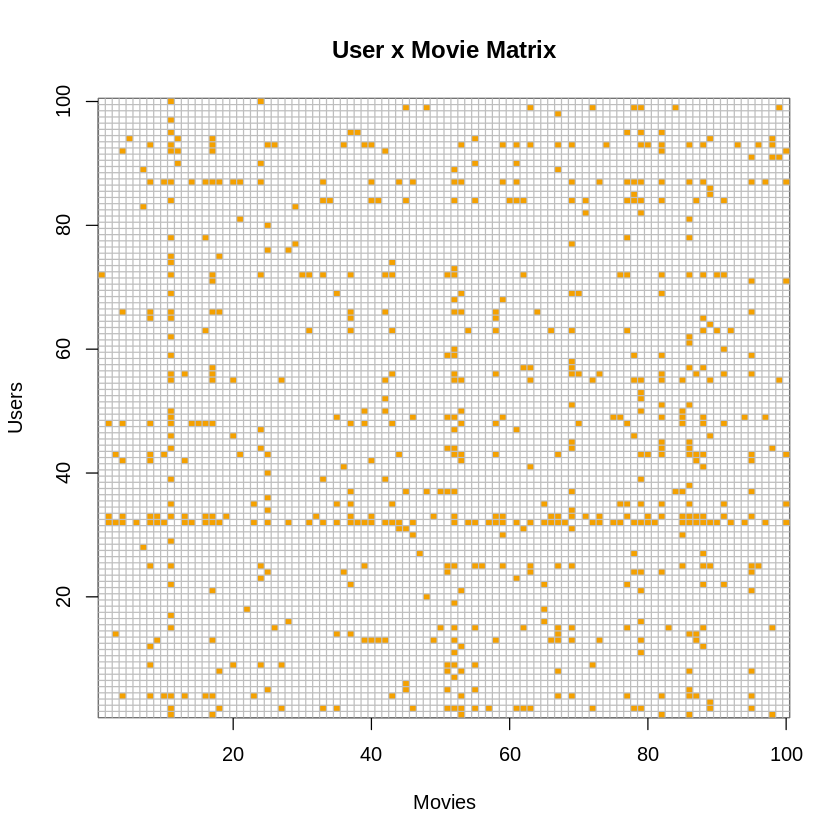

In [ ]:
users <- sample(unique(edx$userId), 100)
edx %>% filter(userId %in% users) %>%
  select(userId, movieId, rating) %>%
  mutate(rating = 1) %>%
  spread(movieId, rating) %>% 
  select(sample(ncol(.), 100)) %>% 
  as.matrix() %>% t(.) %>%
  image(1:100, 1:100,. , xlab="Movies", ylab="Users")
abline(h=0:100+0.5, v=0:100+0.5, col = "grey")
title("User x Movie Matrix")

In [ ]:
train_set <- train_set %>% select(userId, movieId, rating, title)
test_set  <- test_set  %>% select(userId, movieId, rating, title)

In [ ]:
# Define Mean Absolute Error (MAE)
MAE <- function(true_ratings, predicted_ratings){
  mean(abs(true_ratings - predicted_ratings))
}

# Define Mean Squared Error (MSE)
MSE <- function(true_ratings, predicted_ratings){
  mean((true_ratings - predicted_ratings)^2)
}

# Define Root Mean Squared Error (RMSE)
RMSE <- function(true_ratings, predicted_ratings){
  sqrt(mean((true_ratings - predicted_ratings)^2))
}

In [ ]:
set.seed(4321, sample.kind = "Rounding")

# Create the probability of each rating
p <- function(x, y) mean(y == x)
rating <- seq(0.5,5,0.5)

# Estimate the probability of each rating with Monte Carlo simulation
B <- 10^3
M <- replicate(B, {
  s <- sample(train_set$rating, 100, replace = TRUE)
  sapply(rating, p, y= s)
})
prob <- sapply(1:nrow(M), function(x) mean(M[x,]))

# Predict random ratings
y_hat_random <- sample(rating, size = nrow(test_set), 
                       replace = TRUE, prob = prob)

# Create a table with the error results
result <- tibble(Method = "Project Goal", RMSE = 0.8649, MSE = NA, MAE = NA)
result <- bind_rows(result, 
                    tibble(Method = "Random prediction", 
                           RMSE = RMSE(test_set$rating, y_hat_random),
                           MSE  = MSE(test_set$rating, y_hat_random),
                           MAE  = MAE(test_set$rating, y_hat_random)))

Warning message in set.seed(4321, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


In [ ]:
result

Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.864900,NA,NA
Random prediction,1.577977,2.490012,1.215957


In [ ]:
# Mean of observed values
mu <- mean(train_set$rating)

# Update the error table  
result <- bind_rows(result, 
                    tibble(Method = "Mean", 
                           RMSE = RMSE(test_set$rating, mu),
                           MSE  = MSE(test_set$rating, mu),
                           MAE  = MAE(test_set$rating, mu)))
# Show the RMSE improvement  
result

Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.864900,NA,NA
Random prediction,1.577977,2.490012,1.2159571
Mean,1.115737,1.244870,0.9328077


In [ ]:
# Movie effects (bi)
bi <- train_set %>% 
  group_by(movieId) %>% 
  summarize(b_i = mean(rating - mu))
head(bi)

movieId,b_i
<dbl>,<dbl>
1,0.5695221
2,-0.3359961
3,-0.6045999
4,-0.9101079
5,-0.5772355
6,0.2872977


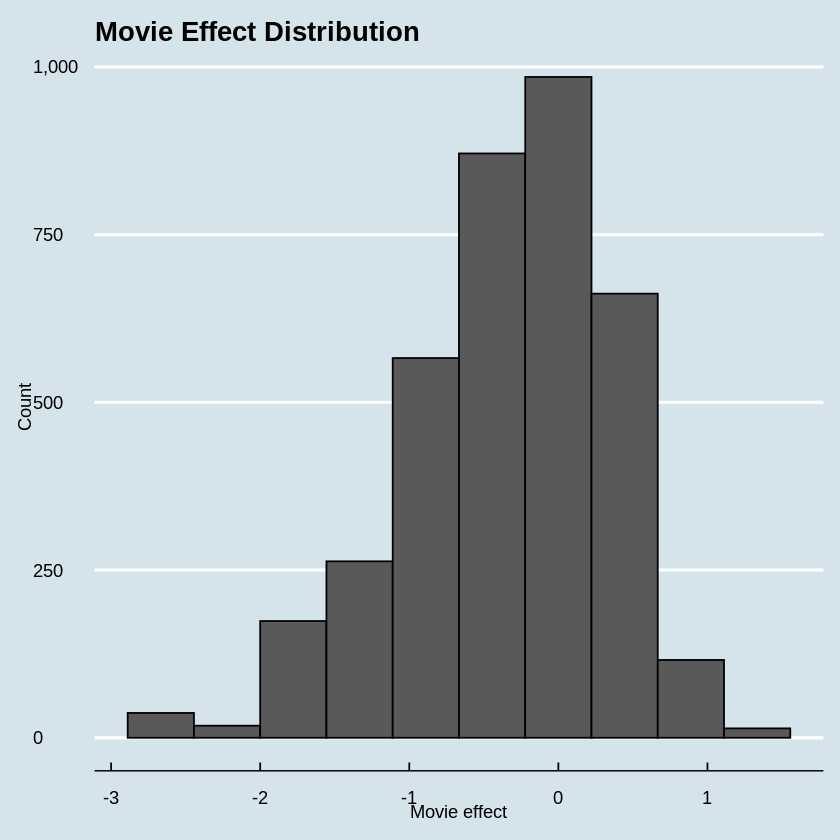

In [ ]:
bi %>% ggplot(aes(x = b_i)) + 
  geom_histogram(bins=10, col = I("black")) +
  ggtitle("Movie Effect Distribution") +
  xlab("Movie effect") +
  ylab("Count") +
  scale_y_continuous(labels = comma) + 
  theme_economist()

In [ ]:
# Predict the rating with mean + bi  
y_hat_bi <- mu + test_set %>% 
  left_join(bi, by = "movieId") %>% 
  .$b_i

# Calculate the RMSE  
result <- bind_rows(result, 
                    tibble(Method = "Mean + bi", 
                           RMSE = RMSE(test_set$rating, y_hat_bi),
                           MSE  = MSE(test_set$rating, y_hat_bi),
                           MAE  = MAE(test_set$rating, y_hat_bi)))

# Show the RMSE improvement  
result

Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.8649000,NA,NA
Random prediction,1.5779770,2.4900116,1.2159571
Mean,1.1157374,1.2448698,0.9328077
Mean + bi,0.9812958,0.9629414,0.7827848


In [ ]:
# User effect (bu)
bu <- train_set %>% 
  left_join(bi, by = 'movieId') %>%
  group_by(userId) %>%
  summarize(b_u = mean(rating - mu - b_i))

# Prediction
y_hat_bi_bu <- test_set %>% 
  left_join(bi, by='movieId') %>%
  left_join(bu, by='userId') %>%
  mutate(pred = mu + b_i + b_u) %>%
  .$pred

# Update the results table
result <- bind_rows(result, 
                    tibble(Method = "Mean + bi + bu", 
                           RMSE = RMSE(test_set$rating, y_hat_bi_bu),
                           MSE  = MSE(test_set$rating, y_hat_bi_bu),
                           MAE  = MAE(test_set$rating, y_hat_bi_bu)))

# Show the RMSE improvement  
result

Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.8649000,NA,NA
Random prediction,1.5779770,2.4900116,1.2159571
Mean,1.1157374,1.2448698,0.9328077
Mean + bi,0.9812958,0.9629414,0.7827848
Mean + bi + bu,0.9109686,0.8298637,0.7182003


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



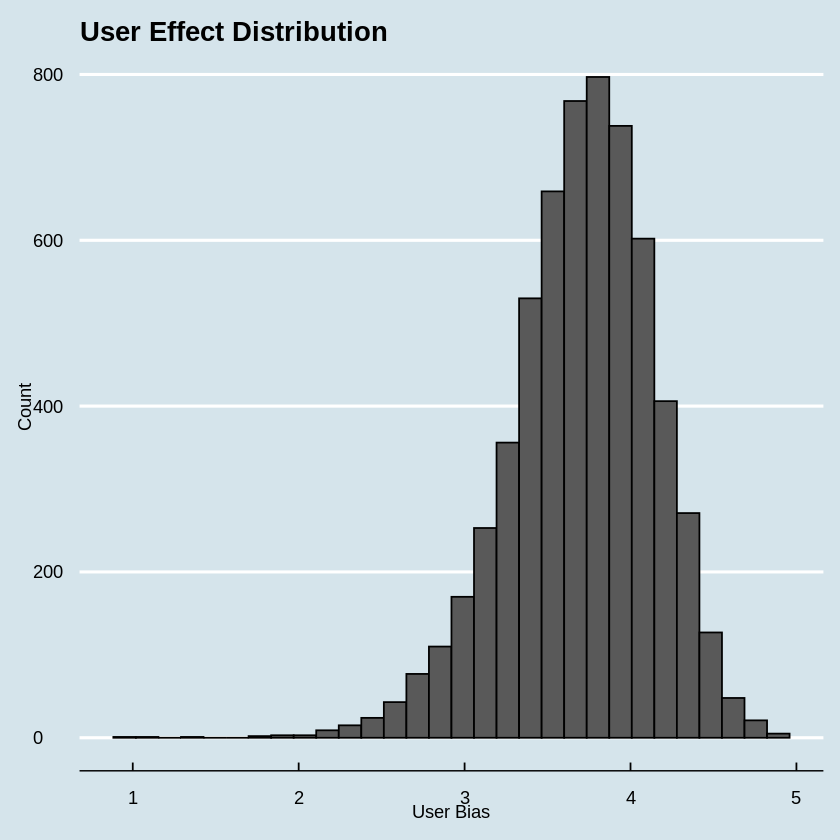

In [ ]:
train_set %>% 
  group_by(userId) %>% 
  summarize(b_u = mean(rating)) %>% 
  filter(n()>=100) %>%
  ggplot(aes(b_u)) + 
    geom_histogram(color = "black") + 
    ggtitle("User Effect Distribution") +
    xlab("User Bias") +
    ylab("Count") +
    scale_y_continuous(labels = comma) + 
    theme_economist()

In [ ]:
train_set %>% 
  left_join(bi, by='movieId') %>%
  mutate(residual = rating - (mu + b_i)) %>%
  arrange(desc(abs(residual))) %>%  
  slice(1:10)

userId,movieId,rating,timestamp,title,genres,b_i,residual
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
3610,2019,1,977888690,Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),Action|Drama,1.0065946,-3.588235
3679,2019,1,976298997,Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),Action|Drama,1.0065946,-3.588235
4354,2019,1,966755771,Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),Action|Drama,1.0065946,-3.588235
1749,318,1,974843197,"Shawshank Redemption, The (1994)",Drama,0.9805455,-3.562186
2686,318,1,973372519,"Shawshank Redemption, The (1994)",Drama,0.9805455,-3.562186
4539,318,1,964684194,"Shawshank Redemption, The (1994)",Drama,0.9805455,-3.562186
5361,318,1,960520667,"Shawshank Redemption, The (1994)",Drama,0.9805455,-3.562186
3662,745,1,966429367,"Close Shave, A (1995)",Animation|Comedy|Thriller,0.9479889,-3.529630
496,3945,5,988514460,Digimon: The Movie (2000),Adventure|Animation|Children's,-2.1110525,3.529412


In [ ]:
titles <- train_set %>% 
  select(movieId, title) %>% 
  distinct()

In [ ]:
bi %>% 
  inner_join(titles, by = "movieId") %>% 
  arrange(-b_i) %>% 
  select(title) %>%
  head()

title
<chr>
"Gate of Heavenly Peace, The (1995)"
Schlafes Bruder (Brother of Sleep) (1995)
Follow the Bitch (1998)
Modulations (1998)
Ulysses (Ulisse) (1954)
Smashing Time (1967)


In [ ]:
bi %>% 
  inner_join(titles, by = "movieId") %>% 
  arrange(b_i) %>% 
  select(title) %>%
  head() 

title
<chr>
"Silence of the Palace, The (Saimt el Qusur) (1994)"
Nueba Yol (1995)
Shadows (Cienie) (1988)
Foreign Student (1994)
"Little Indian, Big City (Un indien dans la ville) (1994)"
Mutters Courage (1995)


In [ ]:
train_set %>% 
  left_join(bi, by = "movieId") %>%
  arrange(desc(b_i)) %>% 
  group_by(title) %>% 
  summarise(n = n()) %>% 
  slice(1:10)

title,n
<chr>,<int>
...And Justice for All (1979),158
"'burbs, The (1989)",244
'Night Mother (1986),56
'Til There Was You (1997),42
"$1,000,000 Duck (1971)",33
1-900 (1994),2
10 Things I Hate About You (1999),565
101 Dalmatians (1961),458
101 Dalmatians (1996),297


In [ ]:
train_set %>% count(movieId) %>% 
  left_join(bi, by="movieId") %>% 
  arrange(desc(b_i)) %>% 
  slice(1:10) %>% 
  pull(n)

[1] 2 1 1 1 1 1 1 1 1 1

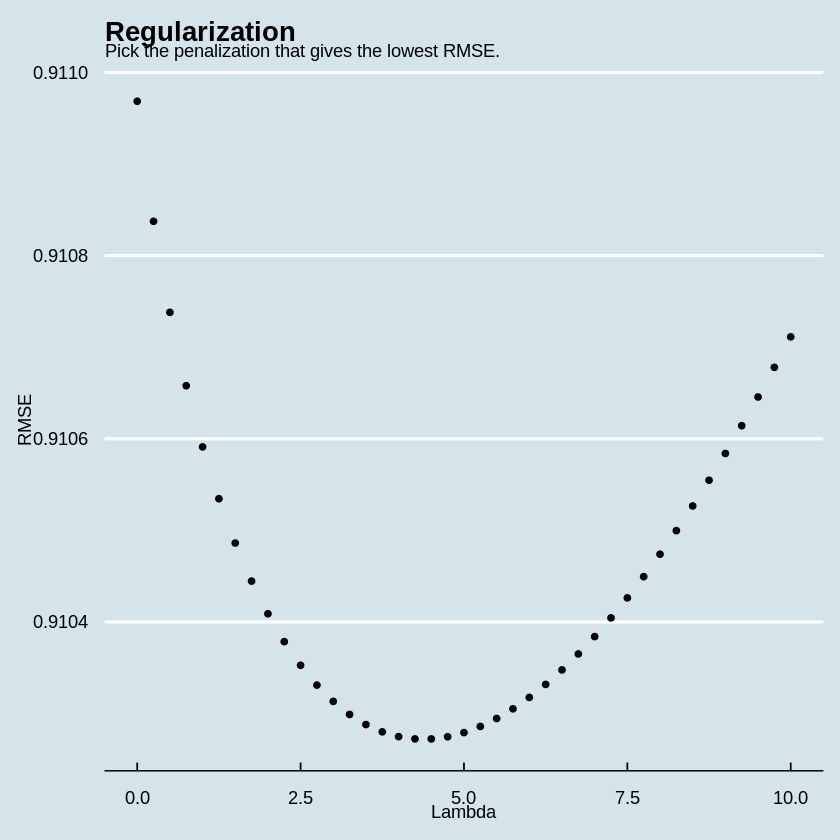

In [ ]:
regularization <- function(lambda, trainset, testset){

  # Mean
  mu <- mean(trainset$rating)

  # Movie effect (bi)
  b_i <- trainset %>% 
    group_by(movieId) %>%
    summarize(b_i = sum(rating - mu)/(n()+lambda))

  # User effect (bu)  
  b_u <- trainset %>% 
    left_join(b_i, by="movieId") %>%
    filter(!is.na(b_i)) %>%
    group_by(userId) %>%
    summarize(b_u = sum(rating - b_i - mu)/(n()+lambda))

  # Prediction: mu + bi + bu  
  predicted_ratings <- testset %>% 
    left_join(b_i, by = "movieId") %>%
    left_join(b_u, by = "userId") %>%
    filter(!is.na(b_i), !is.na(b_u)) %>%
    mutate(pred = mu + b_i + b_u) %>%
    pull(pred)
  
  return(RMSE(predicted_ratings, testset$rating))
}

# Define a set of lambdas to tune
lambdas <- seq(0, 10, 0.25)

# Tune lambda
rmses <- sapply(lambdas, 
                regularization, 
                trainset = train_set, 
                testset = test_set)

# Plot the lambda vs RMSE
tibble(Lambda = lambdas, RMSE = rmses) %>%
  ggplot(aes(x = Lambda, y = RMSE)) +
    geom_point() +
    ggtitle("Regularization", 
            subtitle = "Pick the penalization that gives the lowest RMSE.") +
    theme_economist()

In [ ]:
# We pick the lambda that returns the lowest RMSE.
lambda <- lambdas[which.min(rmses)]

# Then, we calculate the predicted rating using the best parameters 
# achieved from regularization.  
mu <- mean(train_set$rating)

# Movie effect (bi)
b_i <- train_set %>% 
  group_by(movieId) %>%
  summarize(b_i = sum(rating - mu)/(n()+lambda))

# User effect (bu)
b_u <- train_set %>% 
  left_join(b_i, by="movieId") %>%
  group_by(userId) %>%
  summarize(b_u = sum(rating - b_i - mu)/(n()+lambda))

# Prediction
y_hat_reg <- test_set %>% 
  left_join(b_i, by = "movieId") %>%
  left_join(b_u, by = "userId") %>%
  mutate(pred = mu + b_i + b_u) %>%
  pull(pred)

# Update the result table
result <- bind_rows(result, 
                    tibble(Method = "Regularized bi and bu", 
                           RMSE = RMSE(test_set$rating, y_hat_reg),
                           MSE  = MSE(test_set$rating, y_hat_reg),
                           MAE  = MAE(test_set$rating, y_hat_reg)))

# Regularization made a small improvement in RMSE.  
result

Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.8649000,NA,NA
Random prediction,1.5779770,2.4900116,1.2159571
Mean,1.1157374,1.2448698,0.9328077
Mean + bi,0.9812958,0.9629414,0.7827848
Mean + bi + bu,0.9109686,0.8298637,0.7182003
Regularized bi and bu,0.9102723,0.8285956,0.7187747


In [ ]:
train_data <- train_set %>% 
  select(userId, movieId, rating) %>% 
  spread(movieId, rating) %>% 
  as.matrix()

In [ ]:
if(!require(recosystem)) 
  install.packages("recosystem", repos = "http://cran.us.r-project.org")
set.seed(123, sample.kind = "Rounding") # This is a randomized algorithm

library(recosystem)
# Convert the train and test sets into recosystem input format
train_data <-  with(train_set, data_memory(user_index = userId, 
                                           item_index = movieId, 
                                           rating     = rating))
test_data  <-  with(test_set,  data_memory(user_index = userId, 
                                           item_index = movieId, 
                                           rating     = rating))

# Create the model object
r <-  recosystem::Reco()

# Select the best tuning parameters
opts <- r$tune(train_data, opts = list(dim = c(10, 20, 30), 
                                       lrate = c(0.1, 0.2),
                                       costp_l2 = c(0.01, 0.1), 
                                       costq_l2 = c(0.01, 0.1),
                                       nthread  = 4, niter = 10))

 # Train the algorithm  
r$train(train_data, opts = c(opts$min, nthread = 4, niter = 20))

Loading required package: recosystem

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘recosystem’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘float’, ‘RcppProgress’


Warning message in set.seed(123, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


iter      tr_rmse          obj
   0       1.0682   1.2326e+06
   1       0.9230   9.6582e+05
   2       0.8962   9.1600e+05
   3       0.8734   8.7897e+05
   4       0.8545   8.4989e+05
   5       0.8396   8.2774e+05
   6       0.8275   8.1060e+05
   7       0.8172   7.9666e+05
   8       0.8086   7.8511e+05
   9       0.8015   7.7557e+05
  10       0.7958   7.6779e+05
  11       0.7910   7.6138e+05
  12       0.7867   7.5564e+05
  13       0.7832   7.5104e+05
  14       0.7801   7.4663e+05
  15       0.7774   7.4312e+05
  16       0.7751   7.3983e+05
  17       0.7731   7.3705e+05
  18       0.7712   7.3458e+05
  19       0.7695   7.3236e+05


In [ ]:
# Calculate the predicted values  
y_hat_reco <-  r$predict(test_data, out_memory())
head(y_hat_reco, 10)

[1] 4.269004 4.211132 4.643981 4.226493 3.680156 4.401749 4.191503 4.021805
 [9] 3.937639 3.215293

In [ ]:
result <- bind_rows(result, 
                    tibble(Method = "Matrix Factorization - recosystem", 
                           RMSE = RMSE(test_set$rating, y_hat_reco),
                           MSE  = MSE(test_set$rating, y_hat_reco),
                           MAE  = MAE(test_set$rating, y_hat_reco)))
result

Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.8649000,NA,NA
Random prediction,1.5779770,2.4900116,1.2159571
Mean,1.1157374,1.2448698,0.9328077
Mean + bi,0.9812958,0.9629414,0.7827848
Mean + bi + bu,0.9109686,0.8298637,0.7182003
Regularized bi and bu,0.9102723,0.8285956,0.7187747
Matrix Factorization - recosystem,0.8585014,0.7370246,0.6738061


In [ ]:
mu_edx <- mean(edx$rating)

# Movie effect (bi)
b_i_edx <- edx %>% 
  group_by(movieId) %>%
  summarize(b_i = sum(rating - mu_edx)/(n()+lambda))

# User effect (bu)
b_u_edx <- edx %>% 
  left_join(b_i_edx, by="movieId") %>%
  group_by(userId) %>%
  summarize(b_u = sum(rating - b_i - mu_edx)/(n()+lambda))

# Prediction
y_hat_edx <- validation %>% 
  left_join(b_i_edx, by = "movieId") %>%
  left_join(b_u_edx, by = "userId") %>%
  mutate(pred = mu_edx + b_i + b_u) %>%
  pull(pred)

# Update the results table
result <- bind_rows(result, 
                    tibble(Method = "Final Regularization (edx vs validation)", 
                           RMSE = RMSE(validation$rating, y_hat_edx),
                           MSE  = MSE(validation$rating, y_hat_edx),
                           MAE  = MAE(validation$rating, y_hat_edx)))

# Show the RMSE improvement
result 


Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.8649000,NA,NA
Random prediction,1.5779770,2.4900116,1.2159571
Mean,1.1157374,1.2448698,0.9328077
Mean + bi,0.9812958,0.9629414,0.7827848
Mean + bi + bu,0.9109686,0.8298637,0.7182003
Regularized bi and bu,0.9102723,0.8285956,0.7187747
Matrix Factorization - recosystem,0.8585014,0.7370246,0.6738061
Final Regularization (edx vs validation),0.9112194,0.8303208,0.7202435


In [ ]:
validation %>% 
  left_join(b_i_edx, by = "movieId") %>%
  left_join(b_u_edx, by = "userId") %>% 
  mutate(pred = mu_edx + b_i + b_u) %>% 
  arrange(-pred) %>% 
  group_by(title) %>% 
  select(title) %>%
  head(10)

title
<chr>
Saving Private Ryan (1998)
Star Wars: Episode IV - A New Hope (1977)
"Hunt for Red October, The (1990)"
Rear Window (1954)
Aliens (1986)
Star Wars: Episode IV - A New Hope (1977)
"Professional, The (a.k.a. Leon: The Professional) (1994)"
"Sixth Sense, The (1999)"
Raiders of the Lost Ark (1981)


In [ ]:
validation %>% 
  left_join(b_i_edx, by = "movieId") %>%
  left_join(b_u_edx, by = "userId") %>% 
  mutate(pred = mu_edx + b_i + b_u) %>% 
  arrange(pred) %>% 
  group_by(title) %>% 
  select(title) %>%
  head(10)

title
<chr>
Shanghai Surprise (1986)
Porky's II: The Next Day (1983)
I Still Know What You Did Last Summer (1998)
Event Horizon (1997)
Condorman (1981)
"Little Rascals, The (1994)"
Friday the 13th Part VIII: Jason Takes Manhattan (1989)
Super Mario Bros. (1993)
Species II (1998)


In [ ]:
set.seed(1234, sample.kind = "Rounding")

# Convert 'edx' and 'validation' sets to recosystem input format
edx_reco <-  with(edx, data_memory(user_index = userId, 
                                   item_index = movieId, 
                                   rating = rating))
validation_reco  <-  with(validation, data_memory(user_index = userId, 
                                                  item_index = movieId, 
                                                  rating = rating))

# Create the model object
r <-  recosystem::Reco()

# Tune the parameters
opts <-  r$tune(edx_reco, opts = list(dim = c(10, 20, 30), 
                                     lrate = c(0.1, 0.2),
                                     costp_l2 = c(0.01, 0.1), 
                                     costq_l2 = c(0.01, 0.1),
                                     nthread  = 4, niter = 10))

# Train the model
r$train(edx_reco, opts = c(opts$min, nthread = 4, niter = 20))

Warning message in set.seed(1234, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


iter      tr_rmse          obj
   0       1.0700   1.3675e+06
   1       0.9285   1.0779e+06
   2       0.8914   1.0108e+06
   3       0.8628   9.6217e+05
   4       0.8399   9.2746e+05
   5       0.8211   9.0059e+05
   6       0.8054   8.7877e+05
   7       0.7925   8.6174e+05
   8       0.7816   8.4734e+05
   9       0.7728   8.3592e+05
  10       0.7651   8.2655e+05
  11       0.7586   8.1825e+05
  12       0.7533   8.1151e+05
  13       0.7486   8.0589e+05
  14       0.7446   8.0107e+05
  15       0.7409   7.9663e+05
  16       0.7378   7.9274e+05
  17       0.7349   7.8916e+05
  18       0.7325   7.8617e+05
  19       0.7301   7.8336e+05


In [ ]:
# Calculate the prediction
y_hat_final_reco <-  r$predict(validation_reco, out_memory())

# Update the result table
result <- bind_rows(result, 
                    tibble(Method = "Final Matrix Factorization - recosystem", 
                           RMSE = RMSE(validation$rating, y_hat_final_reco),
                           MSE  = MSE(validation$rating, y_hat_final_reco),
                           MAE  = MAE(validation$rating, y_hat_final_reco)))

In [ ]:
# Show the RMSE improvement
result 

Method,RMSE,MSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
Project Goal,0.8649000,NA,NA
Random prediction,1.5779770,2.4900116,1.2159571
Mean,1.1157374,1.2448698,0.9328077
Mean + bi,0.9812958,0.9629414,0.7827848
Mean + bi + bu,0.9109686,0.8298637,0.7182003
Regularized bi and bu,0.9102723,0.8285956,0.7187747
Matrix Factorization - recosystem,0.8585014,0.7370246,0.6738061
Final Regularization (edx vs validation),0.9112194,0.8303208,0.7202435
Final Matrix Factorization - recosystem,0.8538814,0.7291134,0.6709753


In [ ]:
tibble(title = validation$title, rating = y_hat_final_reco) %>%
  arrange(-rating) %>% 
  group_by(title) %>% 
  select(title) %>%
  head(10)

title
<chr>
There's Something About Mary (1998)
East-West (Est-ouest) (1999)
There's Something About Mary (1998)
Austin Powers: International Man of Mystery (1997)
"South Park: Bigger, Longer and Uncut (1999)"
Reservoir Dogs (1992)
There's Something About Mary (1998)
Hellraiser: Bloodline (1996)
Star Wars: Episode IV - A New Hope (1977)


In [ ]:
tibble(title = validation$title, rating = y_hat_final_reco) %>%
  arrange(rating) %>% 
  group_by(title) %>% 
  select(title) %>%
  head(10)

title
<chr>
Bride of Chucky (1998)
Meatballs 4 (1992)
Curse of the Puppet Master (1998)
Nosferatu a Venezia (1986)
All Dogs Go to Heaven 2 (1996)
Hello Mary Lou: Prom Night II (1987)
Wing Commander (1999)
Problem Child 2 (1991)
Phantasm II (1988)


# **THE END**




